In [1]:
import numpy as np
import pandas as pd 

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# EDA

## First Step 

The first step in our data analysis is to read in the input data files into dataframes. 

In [4]:
# load in the training data and use the names.csv to map 
anno_train = pd.read_csv('/Users/smallina/Desktop/Stanford/Data/anno_train.csv', header=None)
names = pd.read_csv('/Users/smallina/Desktop/Stanford/Data/names.csv', header=None)

# Map label numbers in anno_train to car model names using names.csv
# The label column in anno_train is the 5th column (index 5), corresponding to the rows in names.csv

# Map the label to car names
label_to_name = names[0].to_dict()  # Create a dictionary where index maps to car model names
anno_train.columns = ['image', 'x1', 'y1', 'x2', 'y2', 'label']  # Assign column names for clarity
anno_train['car_model'] = anno_train['label'].map(label_to_name)  # Map the label column to car models

# Select and reorder columns: image, x1, y1, x2, y2, car_model
train_df = anno_train[['image', 'x1', 'y1', 'x2', 'y2', 'car_model']]

# Display the first few rows of the structured DataFrame
print(train_df.head())

       image   x1   y1    x2    y2                      car_model
0  00001.jpg   39  116   569   375             Audi R8 Coupe 2012
1  00002.jpg   36  116   868   587           Acura TL Type-S 2008
2  00003.jpg   85  109   601   381        Dodge Magnum Wagon 2008
3  00004.jpg  621  393  1484  1096     Hyundai Elantra Sedan 2007
4  00005.jpg   14   36   133    99  Ford Mustang Convertible 2007


Load in the test dataset

In [6]:
anno_test = pd.read_csv('/Users/smallina/Desktop/Stanford/Data/anno_test.csv', header=None)

# Map label numbers in anno_train to car model names using names.csv
# The label column in anno_train is the 5th column (index 5), corresponding to the rows in names.csv

# Map the label to car names
anno_test.columns = ['image', 'x1', 'y1', 'x2', 'y2', 'label']

# Map the label numbers in anno_test to car model names using the same dictionary
anno_test['car_model'] = anno_test['label'].map(label_to_name)

# Select and reorder columns: image, x1, y1, x2, y2, car_model
test_df = anno_test[['image', 'x1', 'y1', 'x2', 'y2', 'car_model']]

# Display the first few rows of the structured test DataFrame
print(test_df.head())

       image   x1   y1   x2   y2                      car_model
0  00001.jpg   30   52  246  147      Suzuki Kizashi Sedan 2012
1  00002.jpg  100   19  576  203  Ferrari 458 Italia Coupe 2012
2  00003.jpg   51  105  968  659         Jeep Wrangler SUV 2012
3  00004.jpg   67   84  581  407      Toyota Corolla Sedan 2012
4  00005.jpg  140  151  593  339        Toyota Sequoia SUV 2012


Combine the two datasets into one to make data analysis easier

In [7]:
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

# Now combine the two dataframes with the new 'dataset' column included
combined_df = pd.concat([train_df[['image', 'x1', 'y1', 'x2', 'y2', 'car_model', 'dataset']],
                         test_df[['image', 'x1', 'y1', 'x2', 'y2', 'car_model', 'dataset']]], ignore_index=True)

# Display the first few rows of the combined dataframe to verify the 'dataset' column
combined_df.head()

,image,x1,y1,x2,y2,car_model,dataset
0,00001.jpg,39,116,569,375,Audi R8 Coupe 2012,train
1,00002.jpg,36,116,868,587,Acura TL Type-S 2008,train
2,00003.jpg,85,109,601,381,Dodge Magnum Wagon 2008,train
3,00004.jpg,621,393,1484,1096,Hyundai Elantra Sedan 2007,train
4,00005.jpg,14,36,133,99,Ford Mustang Convertible 2007,train


The second step in a classification problem is to figure out how many members there are in each class

In [8]:
car_model_distribution = combined_df['car_model'].value_counts()

# Display the distribution
car_model_distribution.head(10)

car_model
GMC Yukon Hybrid SUV 2012                          136
Chrysler Crossfire Convertible 2008                 97
Mercedes-Benz C-Class Sedan 2012                    96
Nissan Leaf Hatchback 2012                          95
Chevrolet Corvette Ron Fellows Edition Z06 2007     93
Jeep Patriot SUV 2012                               93
Plymouth Neon Coupe 1999                            92
Volkswagen Beetle Hatchback 2012                    92
Audi S5 Convertible 2012                            92
Bentley Continental Flying Spur Sedan 2007          92
Name: count, dtype: int64

In [9]:
car_model_distribution.tail(10)

car_model
Ferrari FF Coupe 2012                67
Aston Martin Virage Coupe 2012       66
Isuzu Ascender SUV 2008              65
Bugatti Veyron 16.4 Coupe 2009       65
Acura TL Sedan 2012                  64
Rolls-Royce Ghost Sedan 2012         61
Chevrolet Avalanche Crew Cab 2012    59
Mazda Tribute SUV 2011               58
FIAT 500 Convertible 2012            55
Hyundai Genesis Sedan 2012           48
Name: count, dtype: int64

The average bounding box size for the images is 574 by 309

In [10]:
combined_df['width'] = combined_df['x2'] - combined_df['x1']
combined_df['height'] = combined_df['y2'] - combined_df['y1']

# Calculate the average width and height
average_width = combined_df['width'].mean()
average_height = combined_df['height'].mean()

average_width, average_height

(573.8356502934816, 308.62255174544333)

In [11]:
q1_width = combined_df['width'].quantile(0.25)
q3_width = combined_df['width'].quantile(0.75)
iqr_width = q3_width - q1_width

q1_height = combined_df['height'].quantile(0.25)
q3_height = combined_df['height'].quantile(0.75)
iqr_height = q3_height - q1_height

# Determine outlier thresholds
width_outlier_min = q1_width - 1.5 * iqr_width
width_outlier_max = q3_width + 1.5 * iqr_width
height_outlier_min = q1_height - 1.5 * iqr_height
height_outlier_max = q3_height + 1.5 * iqr_height

# Identify outliers
outliers = combined_df[(combined_df['width'] < width_outlier_min) | 
                       (combined_df['width'] > width_outlier_max) |
                       (combined_df['height'] < height_outlier_min) | 
                       (combined_df['height'] > height_outlier_max)]

# Count the number of outliers
num_outliers = outliers.shape[0]

# Display the number of outliers and a sample of the outlier data
num_outliers, outliers.head()

(1246,
         image   x1   y1    x2    y2                   car_model dataset  \
 3   00004.jpg  621  393  1484  1096  Hyundai Elantra Sedan 2007   train   
 8   00009.jpg   20  126  1269   771  Nissan Leaf Hatchback 2012   train   
 21  00022.jpg  212  538  1893  1131             BMW X3 SUV 2012   train   
 28  00029.jpg   28  139  1564  1126     Suzuki Aerio Sedan 2007   train   
 53  00054.jpg   58  562  1528  1081  Eagle Talon Hatchback 1998   train   
 
     width  height  
 3     863     703  
 8    1249     645  
 21   1681     593  
 28   1536     987  
 53   1470     519  )

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


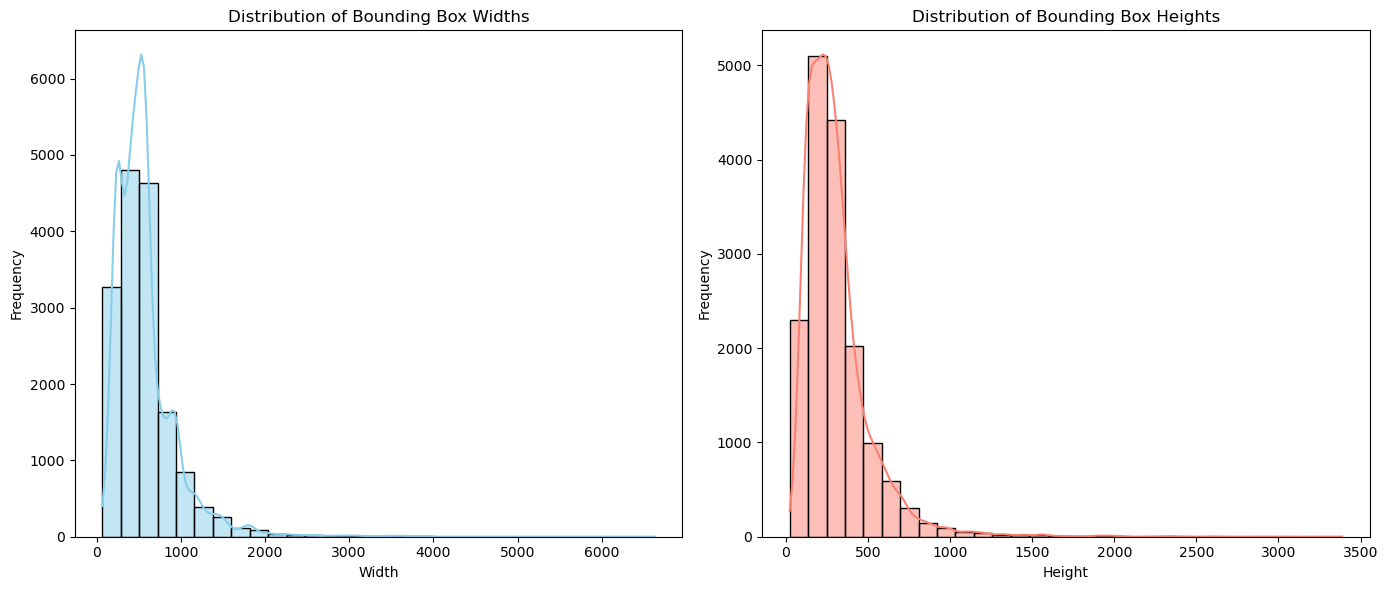

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


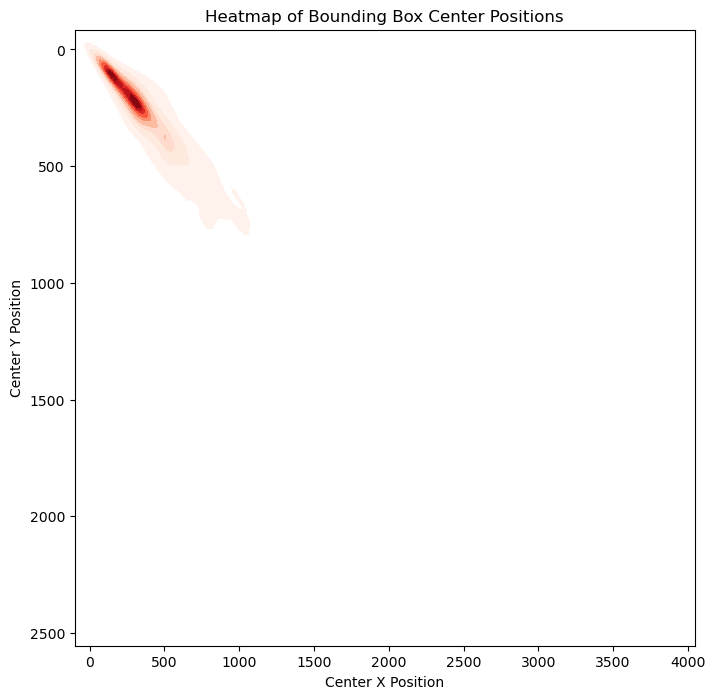

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
plt.figure(figsize=(14, 6))

# Plot histograms for bounding box width and height
plt.subplot(1, 2, 1)
sns.histplot(combined_df['width'], bins=30, kde=True, color="skyblue")
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(combined_df['height'], bins=30, kde=True, color="salmon")
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate the average bounding box position
# For the center of the bounding box, calculate (x1 + x2) / 2 for x and (y1 + y2) / 2 for y
combined_df['center_x'] = (combined_df['x1'] + combined_df['x2']) / 2
combined_df['center_y'] = (combined_df['y1'] + combined_df['y2']) / 2

# Create a heatmap for the center positions of bounding boxes
plt.figure(figsize=(8, 8))
sns.kdeplot(x=combined_df['center_x'], y=combined_df['center_y'], cmap="Reds", fill=True)
plt.title('Heatmap of Bounding Box Center Positions')
plt.xlabel('Center X Position')
plt.ylabel('Center Y Position')
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinate system
plt.show()

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


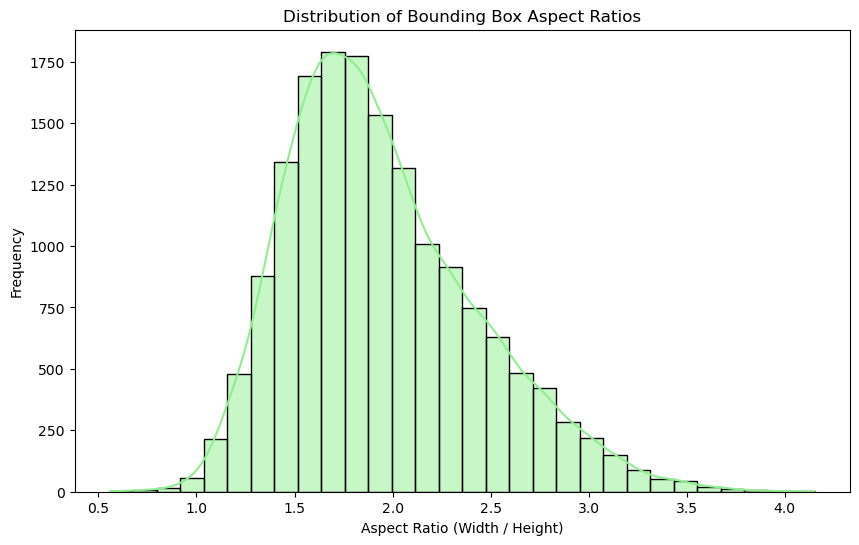

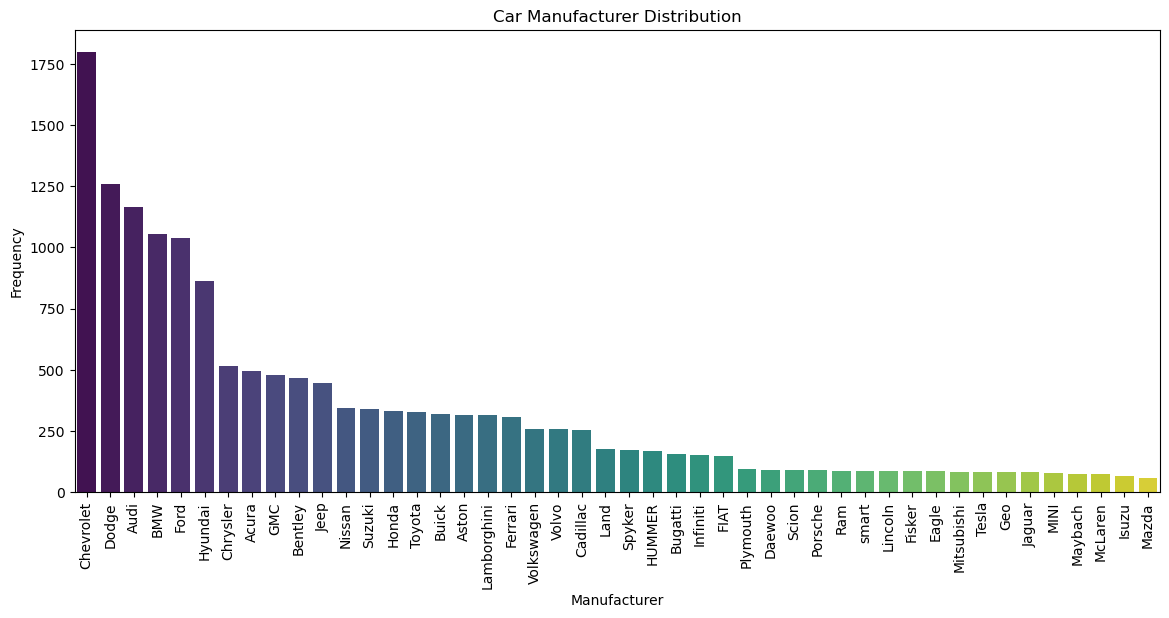

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


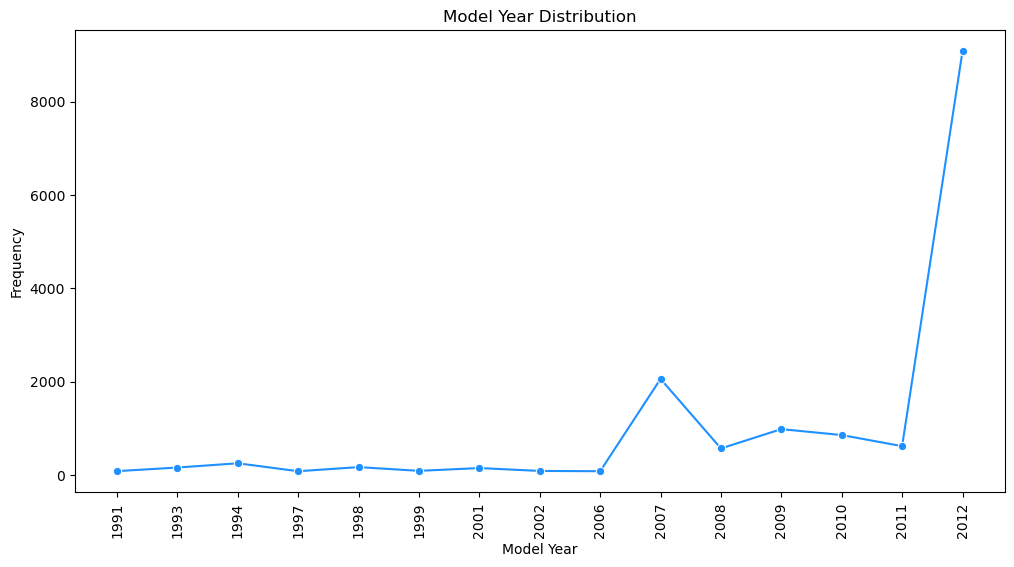

In [13]:
# Step 4: Image-Level Insights
# For this step, let's assume that all images have consistent resolution if available in the combined data.
# Since we don't have the actual images here, I'll demonstrate how to calculate and plot aspect ratios based on bounding box dimensions.

# Calculate the aspect ratio for each bounding box (width / height)
combined_df['aspect_ratio'] = combined_df['width'] / combined_df['height']

# Plot histogram of aspect ratios for bounding boxes
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['aspect_ratio'], bins=30, kde=True, color="lightgreen")
plt.title('Distribution of Bounding Box Aspect Ratios')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.show()

# Step 5: Label Distribution and Analysis
# Extract car manufacturer and model year from car_model if possible
# Assuming car_model follows the format "Manufacturer Model Year"
# Let's split the car_model into Manufacturer, Model, and Year columns

# Split car_model into Manufacturer and Year (splitting by spaces)
combined_df[['manufacturer', 'model_year']] = combined_df['car_model'].str.extract(r'(^[A-Za-z]+)\s.*(\d{4})$')

# Car Manufacturer Distribution
manufacturer_distribution = combined_df['manufacturer'].value_counts()

# Model-Year Distribution
year_distribution = combined_df['model_year'].value_counts().sort_index()

# Plot Car Manufacturer Distribution
plt.figure(figsize=(14, 6))
sns.barplot(x=manufacturer_distribution.index, y=manufacturer_distribution.values, palette="viridis")
plt.title('Car Manufacturer Distribution')
plt.xlabel('Manufacturer')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Plot Model-Year Distribution
plt.figure(figsize=(12, 6))
sns.lineplot(x=year_distribution.index, y=year_distribution.values, marker='o', color="dodgerblue")
plt.title('Model Year Distribution')
plt.xlabel('Model Year')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

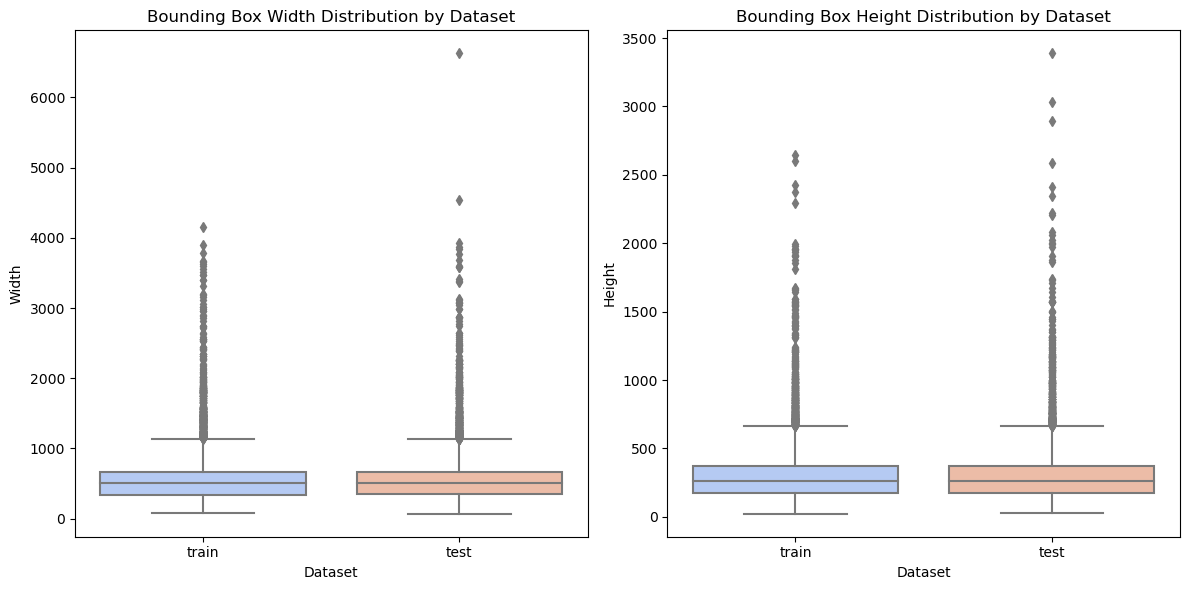

(0, [])

In [14]:
# Step 6: Train/Test Comparison
# Let's compare distributions between train and test for car models and bounding box sizes

# Car Model Distribution by Dataset
train_model_distribution = combined_df[combined_df['dataset'] == 'train']['car_model'].value_counts()
test_model_distribution = combined_df[combined_df['dataset'] == 'test']['car_model'].value_counts()

# Calculate the percentage of car models in both sets
train_model_pct = train_model_distribution / train_model_distribution.sum() * 100
test_model_pct = test_model_distribution / test_model_distribution.sum() * 100

# Find any car models that are present in the training set but not in the test set
unique_train_models = set(combined_df[combined_df['dataset'] == 'train']['car_model'].unique())
unique_test_models = set(combined_df[combined_df['dataset'] == 'test']['car_model'].unique())
missing_test_models = unique_train_models - unique_test_models

# Bounding Box Sizes by Dataset
# Box plots of width and height by dataset
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=combined_df, x='dataset', y='width', palette="coolwarm")
plt.title('Bounding Box Width Distribution by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Width')

plt.subplot(1, 2, 2)
sns.boxplot(data=combined_df, x='dataset', y='height', palette="coolwarm")
plt.title('Bounding Box Height Distribution by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Height')

plt.tight_layout()
plt.show()

# Step 7: Preparing for Modeling
# Encode car model labels as categorical variables
combined_df['car_model_encoded'] = combined_df['car_model'].astype('category').cat.codes

# Display the number of car models missing from the test set
len(missing_test_models), list(missing_test_models)[:5]  # Show the number and first few examples of missing models

<Figure size 1400x800 with 0 Axes>

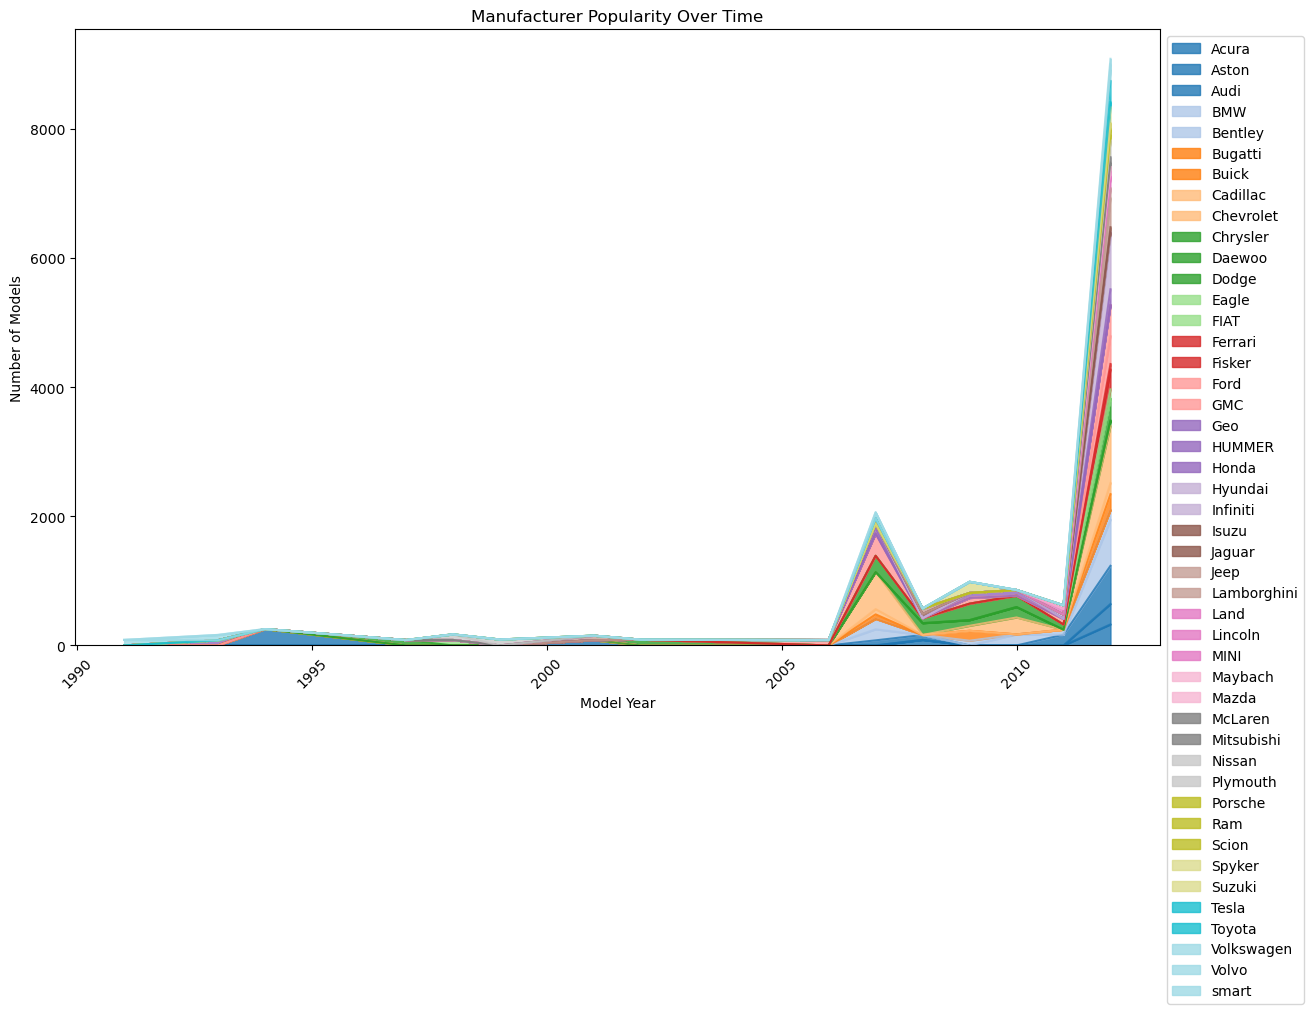

In [15]:
# Group by manufacturer and model year to count occurrences
manufacturer_year_counts = combined_df.groupby(['manufacturer', 'model_year']).size().reset_index(name='count')

# Convert model_year to numeric for proper sorting
manufacturer_year_counts['model_year'] = pd.to_numeric(manufacturer_year_counts['model_year'], errors='coerce')
manufacturer_year_counts = manufacturer_year_counts.dropna(subset=['model_year'])  # Drop rows with invalid year values

# Pivot the data to make it suitable for plotting
manufacturer_year_pivot = manufacturer_year_counts.pivot(index='model_year', columns='manufacturer', values='count').fillna(0)

# Plotting Manufacturer Popularity Over Time
plt.figure(figsize=(14, 8))
manufacturer_year_pivot.plot(kind='area', stacked=True, figsize=(14, 8), cmap='tab20', alpha=0.8)
plt.title('Manufacturer Popularity Over Time')
plt.xlabel('Model Year')
plt.ylabel('Number of Models')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

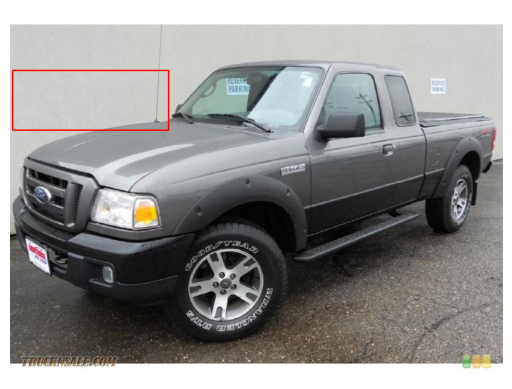

In [16]:
import cv2
import matplotlib.pyplot as plt

# Function to display a sample image with a bounding box
def show_image_with_bbox(image_path, x1, y1, x2, y2):
    image = cv2.imread(image_path)
    if image is not None:
        # Convert the color from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Draw the bounding box on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        print("Image not found:", image_path)

# Example usage
# Assuming images are located in a folder and you have their filenames
# Adjust the path as needed, e.g., f'path_to_images/{filename}'
sample = combined_df.sample(1).iloc[0]
image_filename = sample['image']
image_path = f'/Users/smallina/Desktop/Stanford/Data/cars_train/{image_filename}'
x1, y1, x2, y2 = sample['x1'], sample['y1'], sample['x2'], sample['y2']
show_image_with_bbox(image_path, x1, y1, x2, y2)